# Tasks
## Due 16 April, 2024
1. Transfer Learning for image data using CNN
  - [x] Download about 100 images of ducks and 100 images of chickens from the internet
    Source: <https://www.kaggle.com/datasets/alessiocorrado99/animals10>
  - [x] In a google colab notebook, fine-tune a pre-trained convolutional neural network to classify duck vs chicken and output the classification report

2. Transfer Learning for text data using Transformer
  - [x] Download the sentiment analysis dataset from <https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset>
  - [ ]  Build a sentiment analysis classifier to classify the sentiment into positive, neutral, and negative by fine-tuning a pre-trained transformer model and print your classification report

## References
1. <https://www.analyticsvidhya.com/blog/2021/07/step-by-step-guide-for-image-classification-on-custom-datasets/>
2. <https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html>
3. <https://alvinntnu.github.io/NTNU_ENC2045_LECTURES/temp/sentiment-analysis-using-bert-keras-movie-reviews.html>
4. <https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/>

# Image Data & CNNs

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
IMAGE_SIZE = (224, 224)

In [ ]:
def load_data(path:str):
  x = []
  for folder in os.listdir(path):
      dataset_path = path + "/" + folder
      for img in os.listdir(dataset_path):
          img_arr = cv2.imread(dataset_path + "/" + img)
          img_arr=cv2.resize(img_arr,(224,224))
          x.append(img_arr)

  x = np.array(x)
  x = x / 255.0

  datagen = ImageDataGenerator(rescale = 1./255)

  dataset = datagen.flow_from_directory(path,
                                        target_size=IMAGE_SIZE,
                                        batch_size= 15,
                                        class_mode='sparse')

  y = dataset.classes

  return x, y

In [ ]:
active_dir = "/content/drive/MyDrive/AML - Applied Machine Learning 2024/Cats & Chickens/"

train_path = active_dir + "train"
test_path = active_dir + "test"
val_path = active_dir + "val"

x_train, y_train = load_data(train_path)
x_test, y_test = load_data(test_path)
x_val, y_val = load_data(val_path)

Found 300 images belonging to 2 classes.
Found 33 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
vgg = VGG19(input_shape=list(IMAGE_SIZE) + [3],
            weights='imagenet',
            include_top=False)
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(2,
                   activation='sigmoid')(x)

model = Model(inputs=vgg.input,
              outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [ ]:
#Early stopping to avoid overfitting of model
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',
                         mode='min',
                         verbose=1,
                         patience=5)

# fit the model
history = model.fit(
  x_train,
  y_train,
  validation_data=(x_val,y_val),
  epochs=5,
  callbacks=[early_stop],
  batch_size=20,
  shuffle=True)

Epoch 1/5
15/15 [==============================] - 8s 155ms/step - loss: 1.2922 - accuracy: 0.5900 - val_loss: 0.9070 - val_accuracy: 0.5750
Epoch 2/5
15/15 [==============================] - 2s 135ms/step - loss: 0.4481 - accuracy: 0.8100 - val_loss: 0.3968 - val_accuracy: 0.8000
Epoch 3/5
15/15 [==============================] - 2s 134ms/step - loss: 0.2159 - accuracy: 0.9167 - val_loss: 0.5100 - val_accuracy: 0.7000
Epoch 4/5
15/15 [==============================] - 2s 143ms/step - loss: 0.1287 - accuracy: 0.9700 - val_loss: 0.4089 - val_accuracy: 0.8250
Epoch 5/5
15/15 [==============================] - 2s 136ms/step - loss: 0.0807 - accuracy: 0.9933 - val_loss: 0.3932 - val_accuracy: 0.8750


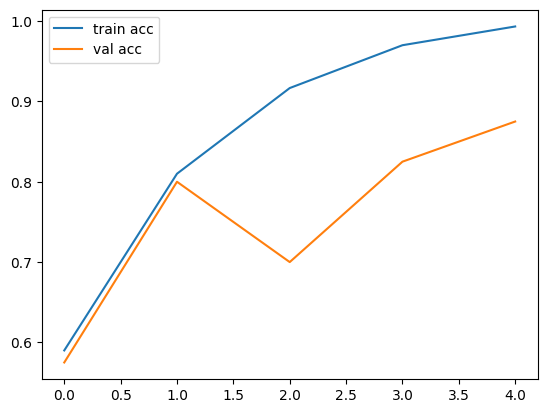

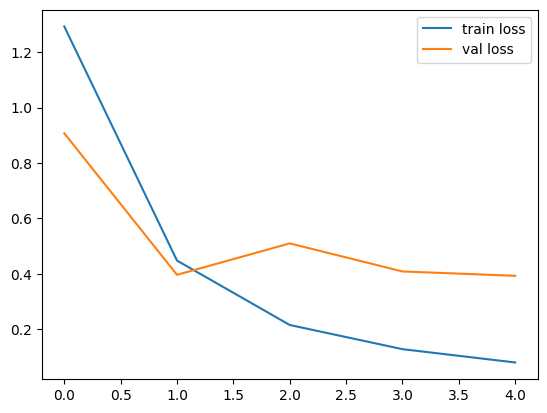

In [ ]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.close()

# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(x_test,
               y_test,
               batch_size=2)

#predict
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

2/2 [==============================] - 0s 128ms/step
              precision    recall  f1-score   support

           0       0.70      0.39      0.50        18
           1       0.52      0.80      0.63        15

    accuracy                           0.58        33
   macro avg       0.61      0.59      0.57        33
weighted avg       0.62      0.58      0.56        33



# Text Data & CNNs